# **RNN Music Analysis and Classification**

The dataset we worked on is taken from [Kaggle](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification) (the data must be dowloaded from http://opihi.cs.uvic.ca/sound/genres.tar.gz, because some audio file on kaggle are damaged). It is about music and it contains 1000 tracks of 30 second length. There are 10 genres, each containing 100 tracks which are all 22050Hz Mono 16-bit audio files in .wav format. The genres are:

- blues
- classical
- country
- disco
- hiphop
- jazz
- metal
- pop
- reggae
- rock

Our goal is to build a supervised classification throught a Neural Network architecture of the musical genre of a given file audio. 


## Import data

Set directory and loading packages

In [ ]:
!mkdir chunks

In [ ]:
!wget http://opihi.cs.uvic.ca/sound/genres.tar.gz

In [ ]:
!cp /content/drive/MyDrive/DLAI/RNN_Music_Analysis/genres.tar.gz /content/genres.tar.gz

In [ ]:
!tar -xf genres.tar.gz

In [ ]:
!rm genres/bextract_single.mf
!rm genres/bl.mf
!rm genres/cl.mf
!rm genres/co.mf
!rm genres/di.mf
!rm genres/hi.mf
!rm genres/input.mf
!rm genres/ja.mf
!rm genres/me.mf
!rm genres/po.mf
!rm genres/re.mf
!rm genres/ro.mf

## Load Data 

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import os
import torchaudio
import itertools
from pydub import AudioSegment
from pydub.utils import make_chunks
import random
from IPython.display import Audio, display 
from sklearn.metrics import classification_report
import time
random.seed(17)
torch.manual_seed(17)
torch.cuda.manual_seed(17)
np.random.seed(17)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(17)
os.environ["PYTHONHASHSEED"] = str(17)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

Before performing our analysis we split each file audio of the dataset into 10 chunks, to obtain a larger dataset composed by tracks of 3 seconds. 

In [ ]:
folders = ['genres/' + i for i in os.listdir('genres/')]
for subf in folders:
    files = [subf + "/" + name for name in os.listdir(subf) if name.count('.') < 3 ]
    for file in files:
        myaudio = AudioSegment.from_file(file , "wav") 
        chunks = make_chunks(myaudio, 3000) 
        genre, name, form = file.split('.')
        for i, chunk in enumerate(chunks):
            if i < 10:
                chunk_name = "chunks/{0}.{1}.{2}.{3}".format(genre.split("/")[2],name,i,form)
                chunk.export(chunk_name, format="wav")
print("Finish")

Finish


We then create a new data frame with 10000 observations and 3 columns, build in the following way: 
- the first column is the file path of each file 
- the second column indicates the labeled genre, and it was extract from the path of each file audio
- the third column shows a numerical index for each musical genre, created with the function `factorize`.


In [ ]:
df = [("chunks/" + name,name.split(".")[0]) for name in os.listdir("chunks/")]
df = pd.DataFrame(df,columns=["path","label"])
df["num_label"] = pd.factorize(df.label)[0]
df = df.sample(frac=1,random_state=200).reset_index(drop=True)
options = {df.label.iloc[i]: df.num_label.iloc[i] for i in range(df.shape[0])}

In [ ]:
print(options)

{'reggae': 8, 'metal': 6, 'jazz': 5, 'hiphop': 4, 'disco': 3, 'blues': 0, 'pop': 7, 'country': 2, 'rock': 9, 'classical': 1}


In [ ]:
df.head()

,path,label,num_label
0,chunks/reggae.00015.9.wav,reggae,8
1,chunks/metal.00033.2.wav,metal,6
2,chunks/reggae.00089.5.wav,reggae,8
3,chunks/jazz.00035.1.wav,jazz,5
4,chunks/hiphop.00031.4.wav,hiphop,4


In [ ]:
df.label.value_counts()

reggae       1000
metal        1000
jazz         1000
hiphop       1000
disco        1000
blues        1000
pop          1000
country      1000
rock         1000
classical    1000
Name: label, dtype: int64

As we can see from the output above, the dataframe is perfectly balanced. 

## Data visualization

 
Python has some libraries for audio processing. In our project we mainly use `Librosa` and `torchaudio`.

At first, we visualize the frequencies of each genre in a plot that shows on the x-axis the time expressed in seconds, and on the y-axis the amplitude (the maximum extent of a vibration or oscillation, measured from the position of equilibrium).

- Frequencies

In [ ]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None, color = "blue"):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1,figsize=(10,2))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1, color = color)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title.upper())
    plt.show(block=False)

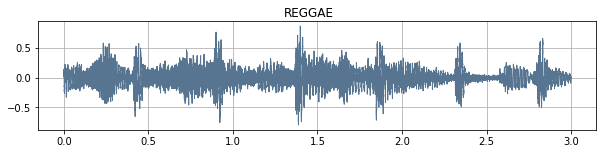

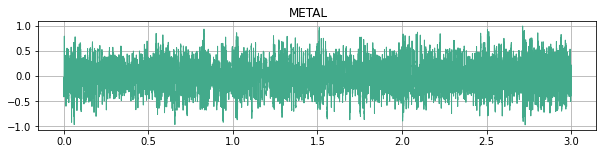

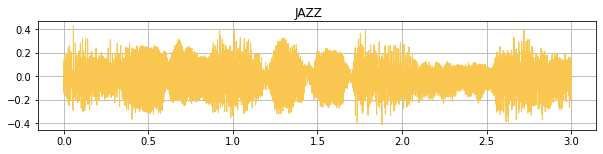

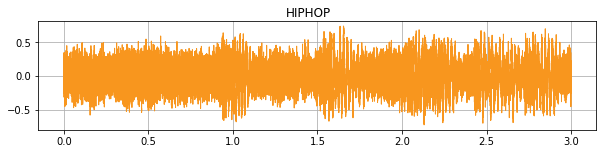

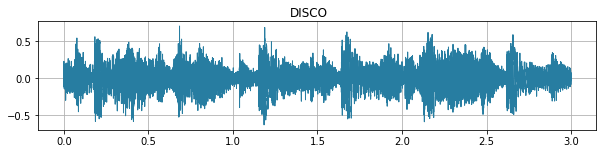

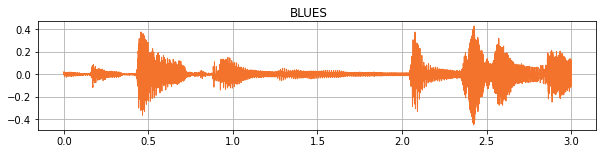

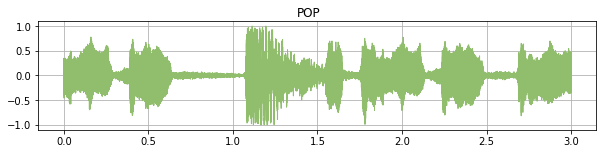

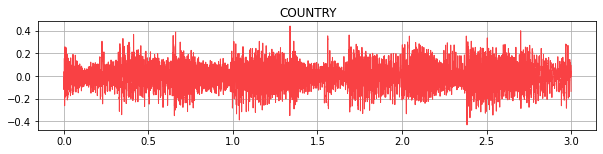

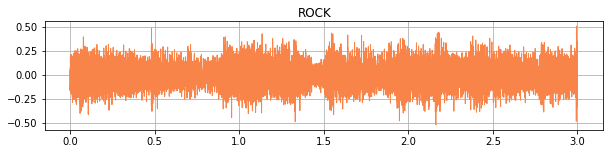

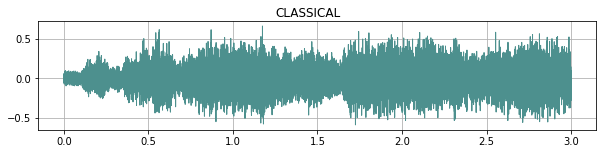

In [ ]:
count = 0
from random import sample
colors = ["#f94144","#f3722c","#f8961e","#f9844a","#f9c74f","#90be6d","#43aa8b","#4d908e","#577590","#277da1"]
colors = sample(colors,10)
for clas in list(options.keys()):
    waveform, sample_rate = torchaudio.load(df.path[df.label == clas].reset_index(drop=True)[0])
    plot_waveform(waveform, sample_rate, title=clas, color = colors[count])
    count += 1

- Spectrogram 

A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform. Not only can one see whether there is more or less energy at, but one can also see how energy levels vary over time.


A spectrogram is usually depicted as a heat map (an image with the intensity shown by varying the color or brightness).

In [ ]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

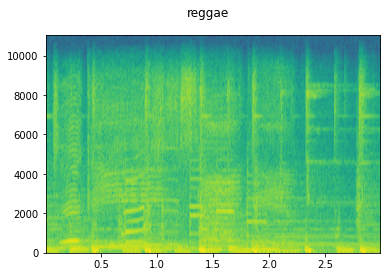

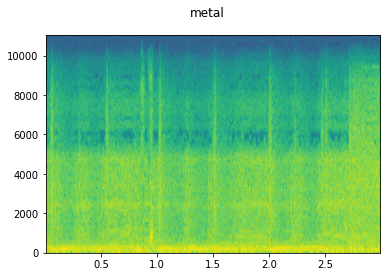

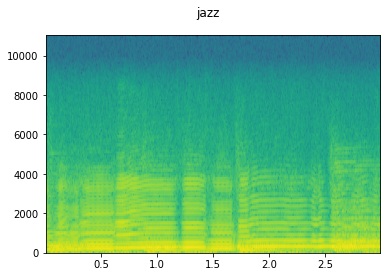

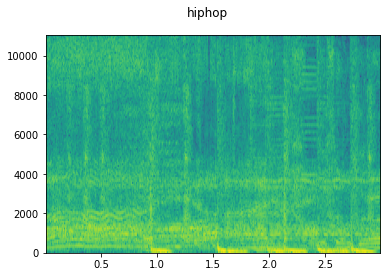

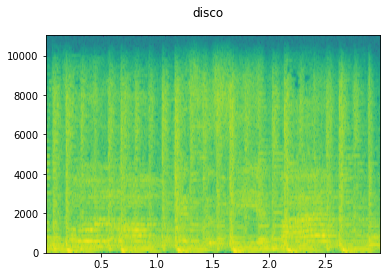

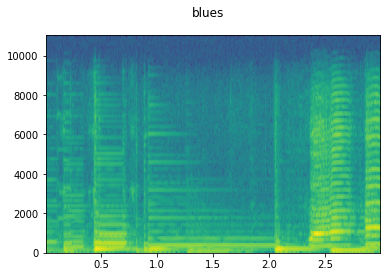

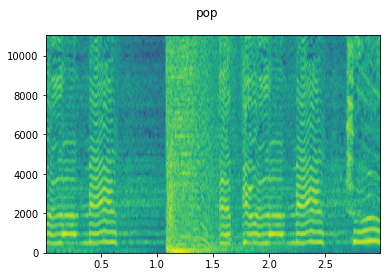

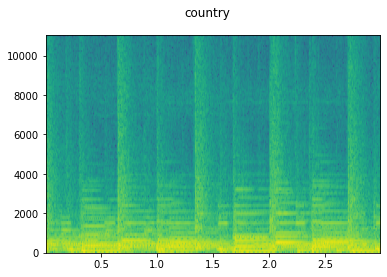

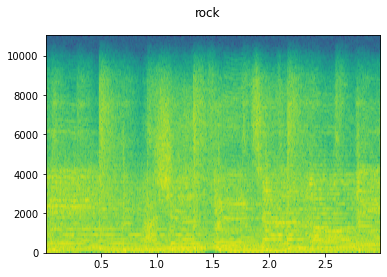

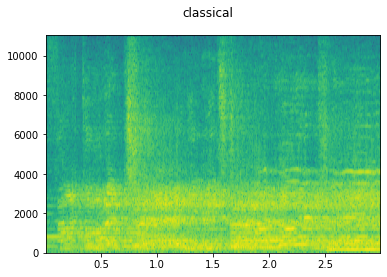

In [ ]:
count = 0
for clas in list(options.keys()):
    waveform, sample_rate = torchaudio.load(df.path[df.label == clas].reset_index(drop=True)[0])
    plot_specgram(waveform, sample_rate, title=clas)
    count += 1

## Build the RNN

The goal of our analysis is to classify the music genre of a given file audio; so, we decided to implement a supervised classification model.
Since the input data are sequencial, we implement a *recurrent neural network*. 
 
Our final network consists in:
- 3 staked LSTM layers; we endowed the outputs of each LSTM layer with a dropout, except the last layer, with a probability equal to dropout (0.2 in our case);
- an additional dropout with probability of 0.2 (set after several trials using different probabilities);
- a linear layer (set after several trials adding a *Relu* and a *sigmoid* activation function). 



In [ ]:
class AudioLSTM(nn.Module):
    def __init__(self, n_feature=5, out_feature=5, n_hidden=256, dropout=0.2, n_layers=3):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_feature = n_feature
        self.out_feature = out_feature
        self.dropout_p = dropout
        self.lstm = nn.LSTM(self.n_feature, self.n_hidden, self.n_layers, dropout=self.dropout_p,batch_first=True)
        self.dropout = nn.Dropout(self.dropout_p) 
        self.fc = nn.Linear(self.n_hidden, self.out_feature)

    def forward(self, x, hidden):
        l_out, l_hidden = self.lstm(x, hidden)
        out = self.dropout(l_out)
        out = self.fc(out[:, -1, :])
        return out, l_hidden

    def init_hidden(self, batch_size, device):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(device))
        return hidden

In [ ]:
in_feature =  80
out_feature =  10
model = AudioLSTM(n_feature=in_feature, out_feature=out_feature)
print(model)

AudioLSTM(
  (lstm): LSTM(80, 256, num_layers=3, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=10, bias=True)
)


### Basic classes and functions

We define the class `Dataset` to let the model read the data. 

Since we had too many features in the file audio, after some trials in which we tried to use a combination of them, the 2 most relevant features seems to be `MelSpectrogram` (is a spectrogram where the frequencies are converted to the mel scale) and `MFCC`(The mel frequency cepstral coefficients of a signal are a small set of features which concisely describe the overall shape of a spectral envelope).

In [ ]:
class Dataset(Dataset):
    def __init__(self,csv):
        self.csv=csv
        self.path = self.csv[:]['path']
        self.labels = np.array(self.csv[:]['num_label'])
  
    def __len__(self):
        return len(self.path)
 
    def __getitem__(self,idx):
        audio, sr=torchaudio.load(self.path[idx])
        sound_data = torch.mean(audio, dim=0, keepdim=True)  
        temp_data = torch.zeros([1, 66000]) 

        if sound_data.numel() < 66000:
            temp_data[:, :sound_data.numel()] = sound_data
        else:
            temp_data = sound_data[:, :66000]

        sound_data = temp_data
        specgram = torchaudio.transforms.MelSpectrogram(sample_rate=sr,n_mels=40)(sound_data)
        mfcc = torchaudio.transforms.MFCC(sample_rate=sr,melkwargs={"n_mels": 40})(sound_data) 
        feature = torch.cat([specgram, mfcc], axis=1)
        lab = self.labels[idx]
        return feature[0].permute(1, 0),lab


Then we build the `train` and `val` function. We used *Adam* as optimizer, *cross entropy* as loss function and we nested a validation set whithin the train set, implementing from scratch an early stopping to avoid overfitting.

We set the following rule: stop training if 20 consecutive times the validation loss does not reach a new minimum. Otherwise, the maximum number of epochs is set to 200.   

In [ ]:
def train(model):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        model.zero_grad()
        output, hidden_state = model(data, model.init_hidden(batch_size = data.shape[0], device = device))
        loss = criterion(output, target)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        train_loss += loss.item()
        pred = torch.max(output, dim=1).indices
        correct += pred.eq(target).cpu().sum().item()
    return train_loss/(batch_idx+1), correct/len(train_loader.dataset)
    

def val(model):
    model.eval()
    correct = 0
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device)
            target = target.to(device)
            output, hidden_state = model(data, model.init_hidden(batch_size = data.shape[0], device = device))
            loss = criterion(output, target)
            val_loss += loss.item()
            pred = torch.max(output, dim=1).indices
            correct += pred.eq(target).cpu().sum().item()
    return val_loss/(batch_idx+1), correct/len(val_loader.dataset)




### Train the model 

In [ ]:
dataset = Dataset(df)

batch_size = 50
epochs = 200
lr = 0.001
torch.cuda.empty_cache()

len_train = int(len(dataset)*0.7)
len_test = len(dataset) - len_train
dataset_train, dataset_test = random_split(dataset, [len_train, len_test])
len_val = int(len_train*0.1)
len_train = len_train - len_val
dataet_train, dataset_val = random_split(dataset_train, [len_train, len_val])

train_loader = DataLoader(dataset_train, batch_size, shuffle=True, generator=g,worker_init_fn=seed_worker)
val_loader = DataLoader(dataset_val, batch_size, shuffle=False, generator=g,worker_init_fn=seed_worker)
test_loader = DataLoader(dataset_test, batch_size, shuffle=False, generator=g,worker_init_fn=seed_worker)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AudioLSTM(n_feature=in_feature, out_feature=out_feature)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
start=time.time()
model.to(device)
res = {"train_loss":[], "train_acc":[], "val_loss":[],"val_acc":[]}
for epoch in range(1,(epochs+1)):
    train_loss, train_acc = train(model)
    val_loss, val_acc = val(model)
    res["train_loss"].append(train_loss)
    res["train_acc"].append(train_acc)
    res["val_loss"].append(val_loss)
    res["val_acc"].append(val_acc)
    print('[{}] train loss {:.6f}, train acc {:.3f}, val loss {:.6f}, val acc {:.3f}'.format(
                epoch, train_loss, train_acc, val_loss, val_acc))
    if epoch == 1:
        best_loss = val_loss
        best_epoch = epoch
        count = 0
        torch.save(model, 'model.pt')
    else:
        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            torch.save(model, 'model.pt')
            count = 0
        else:
            count += 1
            if count == 20:
                model = torch.load("model.pt")
                break
    torch.cuda.empty_cache()
print()
print("Finish")
print()
print(f"Time Execution: {(time.time() - start):.2f}s")

[1] train loss 1.699797, train acc 0.395, val loss 1.426238, val acc 0.490
[2] train loss 1.447243, train acc 0.485, val loss 1.344977, val acc 0.497
[3] train loss 1.314815, train acc 0.537, val loss 1.213711, val acc 0.571
[4] train loss 1.220690, train acc 0.567, val loss 1.111113, val acc 0.614
[5] train loss 1.116488, train acc 0.616, val loss 1.031163, val acc 0.646
[6] train loss 1.044689, train acc 0.648, val loss 1.098830, val acc 0.627
[7] train loss 1.013050, train acc 0.652, val loss 0.893552, val acc 0.704
[8] train loss 0.954757, train acc 0.674, val loss 0.857850, val acc 0.740
[9] train loss 0.929133, train acc 0.678, val loss 0.938852, val acc 0.686
[10] train loss 0.920664, train acc 0.681, val loss 0.834606, val acc 0.709
[11] train loss 0.844865, train acc 0.708, val loss 0.820578, val acc 0.721
[12] train loss 0.802506, train acc 0.732, val loss 0.738841, val acc 0.754
[13] train loss 0.825211, train acc 0.716, val loss 0.652789, val acc 0.784
[14] train loss 0.764

- Results

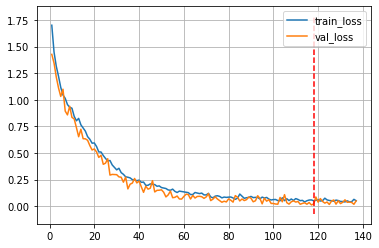

In [ ]:
plt.plot(range(1,(epoch+1)),res["train_loss"], label="train_loss")
plt.plot(range(1,(epoch+1)),res["val_loss"], label="val_loss")
xmin, xmax, ymin, ymax = plt.axis()
plt.vlines((best_epoch+1), ymin = ymin, ymax=ymax, color='red', zorder=2, linestyles="--")
plt.legend()
plt.grid()
plt.show()

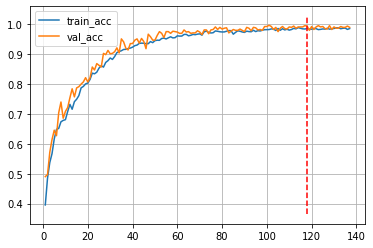

In [ ]:
plt.plot(range(1,(epoch+1)), res["train_acc"], label="train_acc")
plt.plot(range(1,(epoch+1)), res["val_acc"], label="val_acc")
xmin, xmax, ymin, ymax = plt.axis()
plt.vlines((best_epoch+1), ymin = ymin, ymax=ymax, color='red', zorder=2, linestyles="--")
plt.legend()
plt.grid()
plt.show()

- at the end of the process, the model reaches a train accuracy of 0.986 and a train loss of 0.051271;
- The model stops at the 137 iteration, where the validation loss started to increase and the accuracy to became stable. 

### Model evaluation 

In [ ]:
def test(model, test_loader):
    model.eval()
    correct = 0
    y_pred = []
    y_true = []
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device)
        target = target.to(device)
        output, hidden_state = model(data, model.init_hidden(batch_size = data.shape[0], device = device))
        pred = torch.max(output, dim=1).indices
        correct += pred.eq(target).cpu().sum().item()
        y_pred = y_pred + pred.tolist()
        y_true = y_true + target.tolist()
    print(classification_report(y_true, y_pred, target_names = list(options.keys())))
    return y_true, y_pred

In [ ]:
y_true, y_pred = test(model, test_loader)

              precision    recall  f1-score   support

      reggae       0.89      0.87      0.88       292
       metal       0.95      0.91      0.93       300
        jazz       0.80      0.83      0.82       304
      hiphop       0.68      0.81      0.74       305
       disco       0.88      0.80      0.84       299
       blues       0.86      0.87      0.86       295
         pop       0.88      0.86      0.87       330
     country       0.83      0.90      0.86       283
        rock       0.90      0.77      0.83       290
   classical       0.72      0.71      0.71       302

    accuracy                           0.83      3000
   macro avg       0.84      0.83      0.83      3000
weighted avg       0.84      0.83      0.83      3000



In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

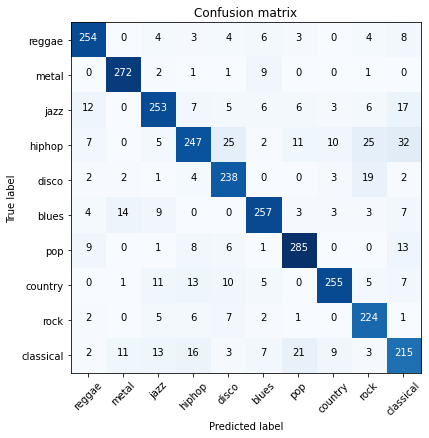

In [ ]:
y_pred = pd.Series(y_pred)
y_true = pd.Series(y_true)
ct = pd.crosstab(y_pred, y_true)
plt.figure(figsize=(6,6))
plot_confusion_matrix(ct.values, list(options.keys()))

### Conclusion

Just looking at the confusion matrix, we see that the majority of the outputs is on the principal diagonal. So, we can conlude that the prediction ability of the model is excellent. 
Indeed, we obtain the followng results: 

- we can rely on the accuracy metric since our dataset is balanced;
- we obtain an overall accuracy of 0.83;
- the worst f1-score is 0.71, although it is a good outcome;  
- **metal** is the class that is predicted better by the model;
- **classical** is the class that is predicted worst. 